In [ ]:
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,  DataLoader
from matplotlib import colors, pyplot as plt
from tqdm.autonotebook import trange
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
#Import virtual_memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime!')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Can using GPU?
train_on_gpu = torch.cuda.is_available()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May  4 09:03:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Google drive
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/simpsons/'  

Mounted at /content/gdrive/


In [ ]:
#Loading kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nataliamakferson","key":"ca6dccdd5f2d31166889e4df373b57e0"}'}

In [ ]:
!pip install kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  

#Loading dataset
!kaggle competitions download -c journey-springfield

!unzip -q /content/journey-springfield.zip

     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=11f2a097b53ef7792f367d4e3083077440962dc2daaf799649d494ea51ddf470
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 98% 513M/521M [00:17<00:00, 31.3MB/s]
100% 521M/521M [00:17<00:00, 31.1MB/s]


**Data loading, preprocess, display and torchvision.**

In [ ]:
# Different dataset modes
DATA_MODES = ['train', 'val', 'test']
# All images will be scaled to 224x224 px
RESCALE_SIZE = 224
# Working on a video card
DEVICE = torch.device("cuda")

In [ ]:
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)    # Files to download
        self.mode = mode  # Working mode
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder() # Encode target labels with value between 0 and n_classes-1.

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    # To convert images to PyTorch tensors and normalize input
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    # Give pictures in one size    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
val_dataset = PasportDataset(val_files, mode='val')   
train_dataset = PasportDataset(train_files, mode='train')

In [ ]:
train_dataset[0]

(tensor([[[-0.9534, -0.9534, -0.9534,  ..., -0.6623, -0.6623, -0.6623],
          [-0.9534, -0.9534, -0.9534,  ..., -0.6623, -0.6623, -0.6623],
          [-0.9534, -0.9534, -0.9534,  ..., -0.6623, -0.6623, -0.6623],
          ...,
          [-1.7925, -1.7925, -1.7925,  ..., -1.8953, -1.8953, -1.8953],
          [-1.7925, -1.7925, -1.7925,  ..., -1.8953, -1.8953, -1.8953],
          [-1.8097, -1.8097, -1.8097,  ..., -1.8953, -1.8953, -1.8953]],
 
         [[-1.7906, -1.7906, -1.7906,  ..., -1.3354, -1.3354, -1.3354],
          [-1.7906, -1.7906, -1.7906,  ..., -1.3354, -1.3354, -1.3354],
          [-1.7906, -1.7906, -1.7906,  ..., -1.3354, -1.3354, -1.3354],
          ...,
          [-1.3354, -1.3354, -1.3354,  ..., -1.4055, -1.4055, -1.4055],
          [-1.3354, -1.3354, -1.3354,  ..., -1.3880, -1.3880, -1.3880],
          [-1.3179, -1.3179, -1.3179,  ..., -1.3880, -1.3880, -1.3880]],
 
         [[-1.7347, -1.7347, -1.7347,  ..., -1.6824, -1.6824, -1.6824],
          [-1.7347, -1.7347,

In [ ]:
# DataLoader
BATCH_SIZE = 128
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

In [ ]:
dataset_sizes

{'train': 16746, 'val': 4187}

**Let's look at the pictures from the dataset**

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    # Imshow for tensors
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

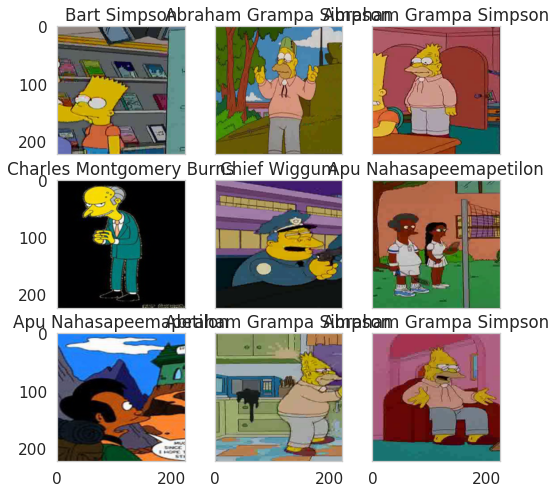

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

There are over 10,000 data in the training dataset.

We will use a model ResNet pre-trained on data from ImagineNet. The data is similar to the data the model was trained on before but with different labels.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):

    best_model_wts = model.state_dict()
    best_f1 = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'val']:
            epoh_preds=[]
            epoh_labels=[]
            if phase == 'train':
              scheduler.step()
              model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                if phase=="train":
                    optimizer.zero_grad()
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                for i,j in zip(preds.cpu().data.numpy(), labels.cpu().data.numpy()):
                    epoh_preds.append(i)
                    epoh_labels.append(j)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = f1_score(epoh_labels, epoh_preds, average='micro')
            losses[phase].append(epoch_loss)
            pbar.set_description('{} Loss: {:.4f} F1 score: {:.4f}'.format(
                                    phase, epoch_loss, epoch_f1))

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()
    print('Best val f1-score: {:4f}'.format(best_f1))
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
def evaluate(model):
    model.eval()
    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        if train_on_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        runninig_correct += int(torch.sum(predicted == labels)) 
    return runninig_correct / dataset_sizes['val']

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
# This is the dimension of the Vector of features coming to the input of the FC layer
num_features = 512
# Replacing the Fully-Connected layer with our linear classifier
model.fc = nn.Linear(num_features, n_classes)

if train_on_gpu:
    model = model.cuda()

# As a cost function, we use cross-entropy
loss_fn = nn.CrossEntropyLoss()

# As an optimizer - AdamW
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# Multiplies learning_rate by 0.1 every 10 epochs 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best val f1-score: 0.966324


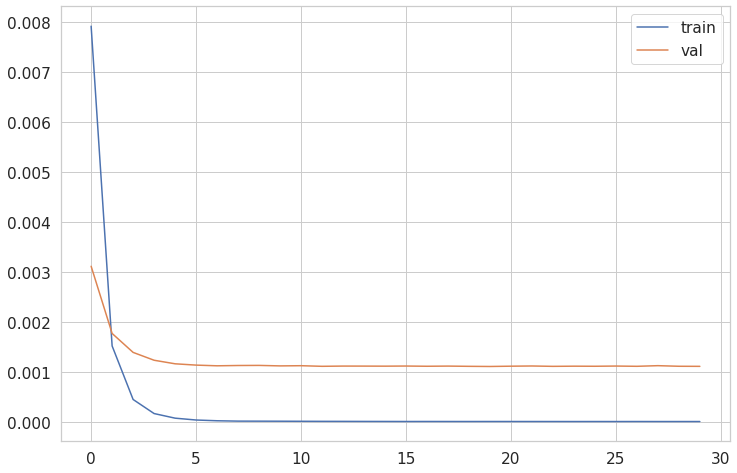

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'ResNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('ResNet_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
print("F1 score: {0:.4f}".format(evaluate(model)))

F1 score: 0.9649


Sabmit on Kaggle.

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_resnet.csv', index=False)

Result on Kaggle:

https://www.kaggle.com/competitions/journey-springfield/leaderboard#

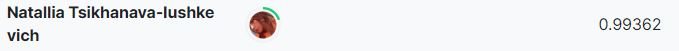